In [19]:
# Keep this cell while WIP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import jax
import jax.random as jrd
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.math.psd_kernels as tfk
from liesel.goose.optim import Stopper, history_to_df

from batram.tmspat_jax.model import TransformationModel
from batram.tmspat_jax.node import (
    OnionCoefPredictivePointProcessGP,
    OnionKnots,
    ModelVar,
    ParamPredictivePointProcessGP
)

key = jrd.PRNGKey(42)

In [21]:
jax.config.update("jax_enable_x64", True)

In [22]:
true_loc = 3.0
true_scale = 1.3
y = true_loc + true_scale * jrd.normal(key, shape=(90, 100))

locs = jrd.uniform(key, shape=(y.shape[1], 2))
knots = OnionKnots(-3.0, 3.0, nparam=12)
locs_var = lsl.Var(locs, name="locs")

coef = OnionCoefPredictivePointProcessGP.new_from_locs(
    knots,
    inducing_locs=lsl.Var(locs[:-50, :], name="inducing_locs_coef"),
    sample_locs=locs_var,
    kernel_cls=tfk.ExponentiatedQuadratic,
    amplitude=lsl.param(1.0, name="amplitude"),
    length_scale=lsl.param(1.0, name="length_scale"),
    name="coef",
)


loc = ParamPredictivePointProcessGP(
    inducing_locs=lsl.Var(locs[:-50, :], name="inducing_locs_loc"),
    sample_locs=locs_var,
    kernel_cls=tfk.ExponentiatedQuadratic,
    amplitude=lsl.param(1.0, name="amplitude_loc"),
    length_scale=lsl.param(0.3, name="length_scale_loc"),
    name="loc",
)

loc.mean.value = y.mean()

scale = ModelVar(y.std(), bijector=tfb.Softplus(), name="scale")

model = TransformationModel(
    y[:-50, :],
    knots=knots.knots,
    coef=coef,
    loc=loc,
    scale=scale,
    parametric_distribution=tfd.Normal,
    to_float32=False,
)

In [23]:
loc.mean.value

Array(3.01853774, dtype=float64)

In [24]:
stopper = Stopper(max_iter=1000, patience=20)

with jax.disable_jit(disable=False):
    result = model.fit_parametric_distributionloc_batched(
        train=y,
        validation=y,
        locs=locs_var,
        stopper=stopper
    )

Training loss: 15678.355, Validation loss: 15678.355:  53%|█████▎    | 533/999 [00:20<00:15, 30.94it/s]

In [25]:
result.position

{'amplitude_loc': Array(3.15082314, dtype=float64),
 'length_scale_loc': Array(0.09001125, dtype=float64),
 'loc_latent': Array([ 0.01024073, -0.03204224,  0.05608062,  0.06058173,  0.07913439,
        -0.03529779, -0.00109854,  0.00442872,  0.01111931,  0.07182171,
         0.02477819, -0.07309398,  0.00240712,  0.05097024,  0.06330915,
         0.08286991, -0.02720374,  0.03853692,  0.02938103,  0.02957554,
         0.19214703,  0.07352558, -0.03918179,  0.05904621,  0.0200632 ,
         0.10849294, -0.03699532, -0.00842268, -0.08045286, -0.04242233,
         0.08756723,  0.03423269, -0.02030336,  0.18672657,  0.02504221,
        -0.08947774,  0.02207203,  0.01182104, -0.03284723, -0.25379749,
         0.13945796, -0.02721823, -0.10902351,  0.01242869, -0.00314282,
        -0.01100439,  0.07873491, -0.00219156, -0.05761012, -0.30410005],      dtype=float64),
 'loc_mean': Array(2.95822145, dtype=float64),
 'scale_transformed': Array(0.98083471, dtype=float64)}

<Axes: xlabel='iteration'>

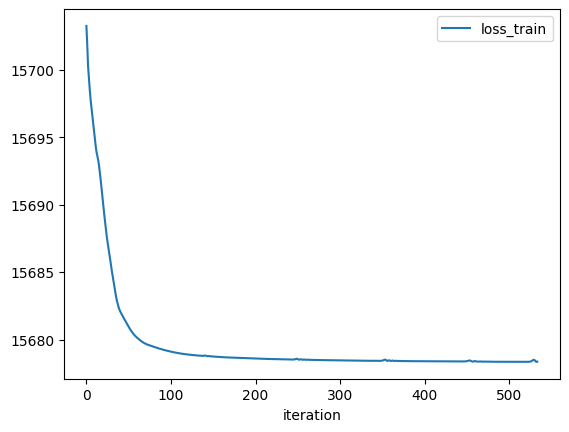

In [26]:
history_to_df(result.history)[["loss_train", "iteration"]].plot("iteration")

<Axes: xlabel='iteration'>

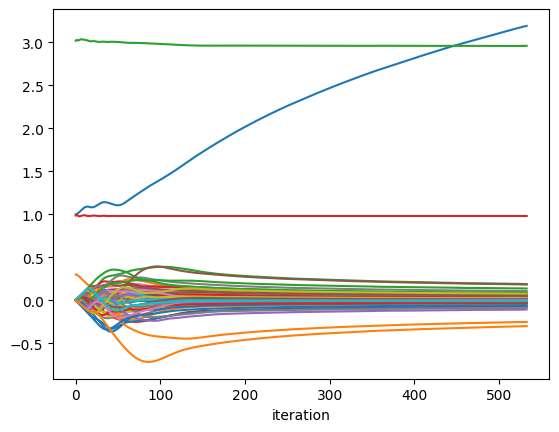

In [27]:
history_to_df(result.history["position"]).plot("iteration", legend=False)

In [28]:
result.model_state["scale_value"].value

Array(1.29928695, dtype=float64)

In [29]:
model.coef.value

Array([[-5.4, -4.8, -4.2, ...,  4.2,  4.8,  5.4],
       [-5.4, -4.8, -4.2, ...,  4.2,  4.8,  5.4],
       [-5.4, -4.8, -4.2, ...,  4.2,  4.8,  5.4],
       ...,
       [-5.4, -4.8, -4.2, ...,  4.2,  4.8,  5.4],
       [-5.4, -4.8, -4.2, ...,  4.2,  4.8,  5.4],
       [-5.4, -4.8, -4.2, ...,  4.2,  4.8,  5.4]], dtype=float64)

In [30]:
model.coef.latent_coef.sample_locs.value.value = locs

In [33]:
model.transformation_and_logdet(y, locs)

(Array([[ 0.23505315,  0.87985828,  0.74310155, ...,  0.5431385 ,
         -1.31602309,  1.55345958],
        [ 0.05323521,  0.44097162, -2.35377202, ..., -0.00499251,
          0.15907294, -0.7425544 ],
        [ 1.64760281,  1.99694509, -1.21884129, ...,  0.23633515,
          0.23231708, -1.05488765],
        ...,
        [-0.80856657,  1.31501447, -0.68085321, ..., -1.68863475,
         -1.19797706,  0.21948106],
        [-0.03930757, -0.75326709, -1.36564066, ...,  1.69002079,
         -0.76165527,  0.91518868],
        [ 0.17557124,  0.33152793, -0.36515707, ...,  0.27769058,
         -0.71514908,  1.58637274]], dtype=float64),
 Array([[-0.26181563, -0.26181563, -0.26181563, ..., -0.26181563,
         -0.26181563, -0.26181563],
        [-0.26181563, -0.26181563, -0.26181563, ..., -0.26181563,
         -0.26181563, -0.26181563],
        [-0.26181563, -0.26181563, -0.26181563, ..., -0.26181563,
         -0.26181563, -0.26181563],
        ...,
        [-0.26181563, -0.26181563, -0.2